# Resnet + Transfer Learning
 
Notebook para testar o uso da VGG para uma nova aplicação, através do uso de Transfer Learning.

Iremos usar o tensorflow e keras

será usado o problema de classificação de imagens de frutas

In [12]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.resnet import ResNet50, preprocess_input
# from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array


from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

#### variaveis uteis

In [3]:

IMAGE_SIZE = [100, 100] # feel free to change depending on dataset

In [4]:
# training config:
epochs = 16
batch_size = 32

#### dataset

In [5]:
train_path = 'fruits-dataset/fruits-360_dataset/fruits-360/Training'
valid_path = 'fruits-dataset/fruits-360_dataset/fruits-360/Test'

In [6]:
# numero de arquivos
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

In [7]:
print(len(image_files), len(valid_image_files))

67692 22688


In [8]:
# numero de classes
folders = glob(train_path + '/*')

print(len(folders))

131


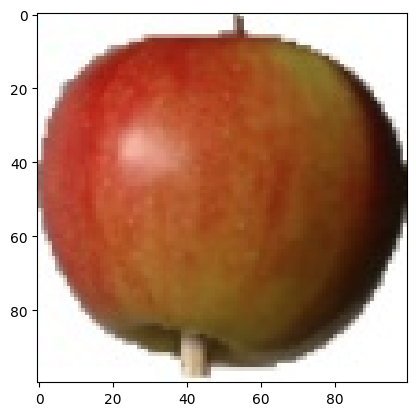

In [13]:
# verificando uma imagem
plt.imshow(load_img(np.random.choice(image_files)))
plt.show()

### Model

In [14]:
# removando a ultima camada da rede para realizarmos o treinamento posterior
res = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

94765736/94765736 [==============================] - 7s 0us/step


In [15]:
# congelando os pesos para não serem treinados
for layer in res.layers:
  layer.trainable = False


In [16]:
# nova camada sendo adicionada com o numero de saidas igual ao numero de classes
x = Flatten()(res.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [17]:
# juntando tudo em um objeto model
model = Model(inputs=res.input, outputs=prediction)

In [18]:
# visualizando estrutura da rede
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1_conv[0][0]']         

In [19]:
# definido função de custo e otimizador
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [21]:
# criar instancia do ImageDataGenerator
gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)

In [22]:
val_gen = ImageDataGenerator( preprocessing_function=preprocess_input)

In [23]:
# get label mapping for confusion matrix plot later
test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

Found 22688 images belonging to 131 classes.
{'Apple Braeburn': 0, 'Apple Crimson Snow': 1, 'Apple Golden 1': 2, 'Apple Golden 2': 3, 'Apple Golden 3': 4, 'Apple Granny Smith': 5, 'Apple Pink Lady': 6, 'Apple Red 1': 7, 'Apple Red 2': 8, 'Apple Red 3': 9, 'Apple Red Delicious': 10, 'Apple Red Yellow 1': 11, 'Apple Red Yellow 2': 12, 'Apricot': 13, 'Avocado': 14, 'Avocado ripe': 15, 'Banana': 16, 'Banana Lady Finger': 17, 'Banana Red': 18, 'Beetroot': 19, 'Blueberry': 20, 'Cactus fruit': 21, 'Cantaloupe 1': 22, 'Cantaloupe 2': 23, 'Carambula': 24, 'Cauliflower': 25, 'Cherry 1': 26, 'Cherry 2': 27, 'Cherry Rainier': 28, 'Cherry Wax Black': 29, 'Cherry Wax Red': 30, 'Cherry Wax Yellow': 31, 'Chestnut': 32, 'Clementine': 33, 'Cocos': 34, 'Corn': 35, 'Corn Husk': 36, 'Cucumber Ripe': 37, 'Cucumber Ripe 2': 38, 'Dates': 39, 'Eggplant': 40, 'Fig': 41, 'Ginger Root': 42, 'Granadilla': 43, 'Grape Blue': 44, 'Grape Pink': 45, 'Grape White': 46, 'Grape White 2': 47, 'Grape White 3': 48, 'Grape Wh

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -69.482704 max: 151.061


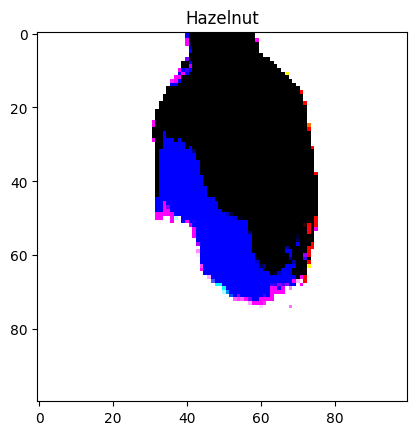

In [27]:
# vissualizar uma amostra
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break


In [28]:
# create generators
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
  class_mode='sparse'
)
valid_generator = val_gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
  class_mode='sparse'
)

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


 - treinamento

In [32]:
# fit the model
r = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)

Epoch 1/16
2115/2115 [==============================] - 2168s 1s/step - loss: 1.3111 - accuracy: 0.9140 - val_loss: 2.9169 - val_accuracy: 0.9229
Epoch 2/16
2115/2115 [==============================] - 1833s 867ms/step - loss: 0.7405 - accuracy: 0.9675 - val_loss: 1.7259 - val_accuracy: 0.9544
Epoch 3/16
2115/2115 [==============================] - 1841s 871ms/step - loss: 0.5931 - accuracy: 0.9783 - val_loss: 1.5798 - val_accuracy: 0.9621
Epoch 4/16
2115/2115 [==============================] - 1797s 850ms/step - loss: 0.4959 - accuracy: 0.9832 - val_loss: 2.1342 - val_accuracy: 0.9595
Epoch 5/16
2115/2115 [==============================] - 1720s 813ms/step - loss: 0.4446 - accuracy: 0.9861 - val_loss: 1.9594 - val_accuracy: 0.9662
Epoch 6/16
2115/2115 [==============================] - 1724s 815ms/step - loss: 0.4364 - accuracy: 0.9879 - val_loss: 2.1018 - val_accuracy: 0.9680
Epoch 7/16
2115/2115 [==============================] - 1710s 808ms/step - loss: 0.3368 - accuracy: 0.9907 - 

In [31]:
def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm

In [ ]:
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)